In [1]:
%load_ext autoreload
%autoreload 2

# Genetic Algorithm approach for solving the problem of Project 2.

## Genetic Algorithm proposal:

- **Genetic Algorithm** is a search heuristic that is inspired by Charles Darwin’s theory of natural evolution. This algorithm reflects the process of natural selection where the fittest individuals are selected for reproduction in order to produce offspring of the next generation.
- The algorithm starts with a population of solutions (represented by chromosomes) and applies the principle of natural selection to evolve the population of solutions.
    - For our case, chromosomes will represent the variables used in the model.
    - Given the size of the problem, we will first manually select the best 50 variables using the best performing feature selection method.
    - The genetic algorithm will then be used to select the best subset of these 50 variables.
    - We will also choose the model "manually" during the selection of the best 50 variables.
- The genetic algorithm will be implemented as follows:
    - The fitness function will be the profit function.
    - The genetic operators will be mutation and crossover.
    - The selection operator will be the tournament selection.
    - The stopping criterion will be the number of generations or the number of generations without improvement.
    - The initial population will be generated randomly.
    - The mutation probability will be set to 0.1, and the crossover probability will be set to 0.9. 


In [2]:
%pip install pygad

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 965.5 kB/s eta 0:00:000:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pickle
 
with open('selected_features_per_method.pkl', 'rb') as f:
    selected_features = pickle.load(f)

selected_features

{'mrmr': Index([105,  64, 131, 136, 100, 102,  24, 103, 104, 359, 101,  29, 266,  57,
         39, 241, 351, 155, 335, 442],
       dtype='int64'),
 'surf': Index([105, 102, 101, 321, 100, 289, 283, 374, 254, 311,
        ...
        378, 228, 354, 394, 232, 332, 299, 279, 356, 382],
       dtype='int64', length=490),
 'forest': Index([100, 101, 102, 103, 104, 105, 403], dtype='int64'),
 'xgb': Index([100, 101, 102, 103, 104, 105], dtype='int64'),
 'common_features': [105.0,
  64.0,
  131.0,
  136.0,
  100.0,
  102.0,
  24.0,
  103.0,
  104.0,
  359.0,
  101.0,
  29.0,
  266.0,
  57.0,
  39.0,
  241.0,
  351.0,
  155.0,
  335.0,
  442.0,
  403.0],
 'intersection_common_features': [105.0, 100.0, 102.0, 103.0, 104.0, 101.0]}

In [3]:
import pandas as pd
import numpy as np
from utils import cleanup_dataset_apply_standard_scaler

In [4]:
X = pd.read_table('./data/x_train.txt', header=None, delimiter=' ')
y = pd.read_table('./data/y_train.txt', header=None)

X_test = pd.read_table('./data/x_test.txt', header=None, delimiter=' ')

X.head()

correlated_features_to_remove = [1, 0, 4, 6, 7, 3, 5, 8, 9, 2]
X = X.drop(correlated_features_to_remove, axis=1)
X_test = X_test.drop(correlated_features_to_remove, axis=1)

X = cleanup_dataset_apply_standard_scaler(X)
X_test = cleanup_dataset_apply_standard_scaler(X_test)

In [5]:
from sklearn.ensemble import RandomForestClassifier

best_best_features = [100, 102, 105, 101, 103, 104, 64]

# Grid search best hyperparameters
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': np.arange(100, 1000, 100),
    'max_depth': np.arange(1, 30, 1),
    'max_features': np.arange(1, 15, 1),
    'bootstrap': [True, False]
}

clf = RandomForestClassifier(random_state=0, n_jobs=1)
grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, verbose=4)
grid_search.fit(X[pd.Index(best_best_features)], y.values.ravel())
grid_search.best_params_

Fitting 5 folds for each of 7308 candidates, totalling 36540 fits


KeyboardInterrupt: 

In [77]:
from typing import List
from pygad import pygad
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from utils import train_and_evaluate_model, max_score

X_eval_train, X_eval_test, y_eval_train, y_eval_test = train_test_split(X, y, test_size=0.2, random_state=0)
common_features = pd.Index(selected_features['common_features'], dtype='int64')

def apply_optimized_forest(
        X: pd.DataFrame,
        y: pd.Series,
        X_test: pd.DataFrame,
        random_state: int = 0
) -> pd.Series:
    """
    Apply the optimized random forest model to the dataset.
    :param X: pd.DataFrame - The training dataset.
    :param y: pd.Series - The target variable.
    :param X_test: pd.DataFrame - The test dataset.
    :param random_state: int - The random state.
    :return: pd.Series - The predictions.
    """
    
    model = RandomForestClassifier(
        n_estimators=500,
        max_depth=9,
        max_features=1,
        bootstrap=True,
        random_state=random_state,
        n_jobs=-1,
    )

    model.fit(X, y)
    return pd.Series(model.predict_proba(X_test)[:, 1], index=X_test.index)


def fitness_function_forest(
        ga_instance: pygad.GA,
        solution: List[int],
        solution_idx: int
) -> float:
    solution = list(map(bool, solution))
    
    if not any(solution):
        return 0
    
    score = train_and_evaluate_model(
        model=apply_optimized_forest,
        X_train=X_eval_train,
        y_train=y_eval_train,
        X_test=X_eval_test,
        y_test=y_eval_test,
        selected_features=common_features[solution],
        threshold_num=200,
        should_penalize_feature_num=True,
        random_state=0
    )

    return score / max_score(threshold_num=200)

In [84]:
import logging

ga_forest = pygad.GA(
    num_generations=1000,
    num_parents_mating=10,
    fitness_func=fitness_function_forest,
    sol_per_pop=50,
    gene_type=int,
    gene_space=[0, 1],
    num_genes=len(common_features),
    init_range_low=0,
    init_range_high=1,
    mutation_percent_genes=10,
    crossover_probability=0.9,
    mutation_probability=0.1,
    parent_selection_type='tournament',
    keep_parents=2,
    crossover_type='single_point',
    mutation_type='random',
    random_mutation_min_val=0,
    random_mutation_max_val=1,
    random_seed=0,
    save_best_solutions=True,
    logger=logging.getLogger(),
    stop_criteria="reach_0.8",
    parallel_processing=None
)

In [85]:
ga_forest.run()

KeyboardInterrupt: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


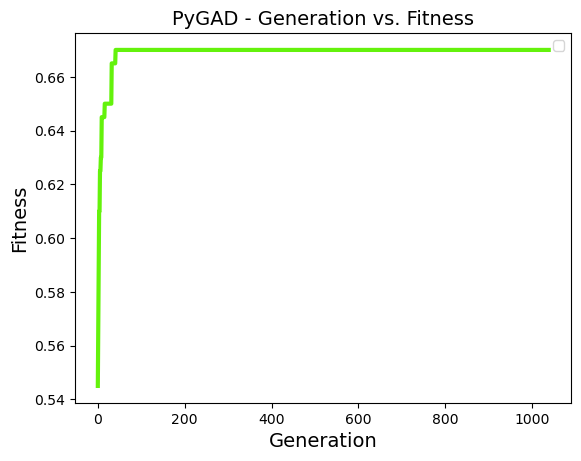

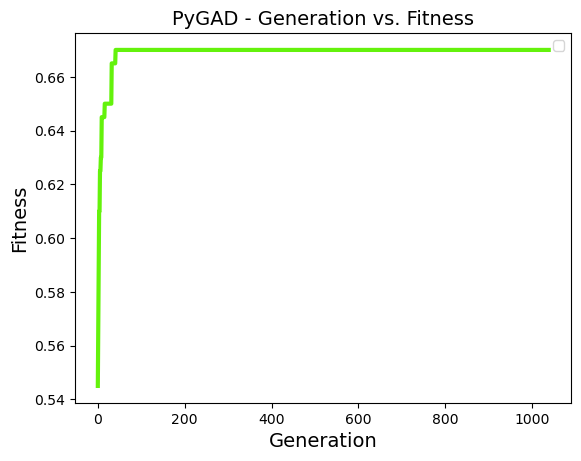

In [86]:
ga_forest.plot_fitness()

In [87]:
ga_forest.save('genetic_algorithm_solution_for_forest')

In [79]:
solution, solution_fitness, solution_id = ga_forest.best_solution()

In [82]:
solution = list(map(bool, solution))
common_features[solution], solution_fitness

(Index([102, 103, 104, 101, 39], dtype='int64'), 0.67)

In [91]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svm_best_features = selected_features['intersection_common_features']

# Grid search best hyperparameters

param_grid = {
    'C': np.logspace(-4, 4, 20),
    'gamma': np.logspace(-4, 4, 20),
    'kernel': ['rbf'],
    'class_weight': [
        {0: i, 1: j}
        for i in np.arange(1, 10, 1)
        for j in np.arange(1, 10, 1)
    ]
}

clf = SVC(
    random_state=0,
    kernel='rbf'
)

grid_search = GridSearchCV(
    clf, 
    param_grid, 
    cv=5,
    n_jobs=-1,
    verbose=4
)
grid_search.fit(X[pd.Index(svm_best_features)], y.values.ravel())
grid_search.best_params_

Fitting 5 folds for each of 32400 candidates, totalling 162000 fits


KeyboardInterrupt: 